# Classification

In this model, we used TPOT to automatically pick the best classifier and hyperparameters. We also included multiple-sequence aligned data for comparison. Manually tuned model using SVM and GP can be found at `phosphatase_classification`.

## Import Modules

In [27]:
import pickle
import os

# data processing
import pandas as pd
from pandas import DataFrame
import numpy as np
from scipy import stats
import encoding_tools
import matplotlib.pyplot as plt
import scipy

# training and testing
from sklearn import svm, metrics, model_selection
from gpmodel import gpmodel, gpkernel, chimera_tools
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.utils.fixes import loguniform
from sklearn.pipeline import make_pipeline, make_union
from sklearn.tree import DecisionTreeClassifier

# Custom imports
import GP_tools as GP

## Import & Process Data

In [4]:
activations = pd.read_csv('./data/activations.csv', index_col=0)


with open('./data/EFI_ID_List.p', 'rb') as EFI:
    EFIs = pd.Series(map(str, pickle.load(EFI)))
    
with open('./data/metabolite_dict.p', 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)
renaming_dict = dict(zip(range(len(metabolite_dict)), metabolite_dict.values()))

with open('./data/Protein_seq_dict.p', 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)
    

def load_seq(msa=False):
    """
    Load the sequence data. Run before fitting and testing.
    
    Parameters:
        msa (bool): Use MSA aligned sequences (default False)
    """
    Protein_seq_dict = {}
    if msa:
        from Bio import SeqIO
        with open("./data/sequences_muscle.fas") as handle:
            for record in SeqIO.parse(handle, "fasta"):
                Protein_seq_dict[int(record.id)] = str(record.seq.lower())
    else:
        with open('./data/Protein_seq_dict.p', 'rb') as Protein_seq:
            Protein_seq_dict = pickle.load(Protein_seq)
    

def select_X_and_Y(df, x_rows, y_column):
    """
    Select the given X rows and Y column
    """
    # filter out empty columns
    not_dropped = ~pd.isnull(df[y_column])
    not_dropped = pd.Series(not_dropped, index=df.index)
    Ys = df[not_dropped].loc[x_rows, y_column]
    return x_rows, Ys


def process_data(df, threshold=0, transpose=False, renaming=None):
    """
    Convert numerical absorbance data into categorical data
    (active=1, inactive=-1)
    """
    formatted = df > threshold
    if renaming:
        formatted = formatted.rename(renaming)
    if transpose:
        return formatted.transpose() * 2 - 1
    return formatted * 2 - 1


def prepare_train_test(metabolite_name, threshold=0, reshape=True):
    """
    Format the data and return the training set and testing set.
    """
    df = process_data(activations, threshold=threshold, transpose=True, renaming=renaming_dict)
    xs, ys = select_X_and_Y(df, EFIs, metabolite_name)
    
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFIs:
        Padded_dict[ID] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

    mapped_xs = xs.map(OH_dict)
    
    if reshape:
        for i, x in enumerate(mapped_xs):
            mapped_xs[i] = x.reshape(len(x)*21)
        
    X = list(mapped_xs)
    y = ys

    return train_test_split(X, y, test_size=0.2)

## Trained Pipelines
The following pipelines are trained using TPOT with default parameters. Each pipeline corresponds to a specific metabolite.

In [3]:
from stacking_estimator import StackingEstimator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from copy import copy

pipelines = {
    'ATP': make_pipeline(
        StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=6, 
                                                           min_samples_leaf=13, min_samples_split=5, random_state=42)),
        DecisionTreeClassifier(criterion="entropy", max_depth=2, min_samples_leaf=5, min_samples_split=15, random_state=42)
    ),
    'Blank': make_pipeline(
        StackingEstimator(estimator=DecisionTreeClassifier(criterion="gini", max_depth=9, min_samples_leaf=10,
                                                           min_samples_split=5, random_state=42)),
        SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5, learning_rate="invscaling",
                      loss="log", penalty="elasticnet", power_t=0.1, random_state=42)
    ),
    'D-erythronate-4-phosphate': make_pipeline(
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=1.0, 
                                           n_estimators=100, random_state=42), step=0.4),
        MultinomialNB(alpha=0.1, fit_prior=True)
    ),
    'D-threonate-4-phosphate': make_pipeline(
        RBFSampler(gamma=0.5),
        XGBClassifier(learning_rate=0.001, max_depth=2, min_child_weight=2, n_estimators=100,
                      n_jobs=1, subsample=0.8500000000000001, random_state=42, verbosity=0)
    ),
    'Glycerol-2-phospate': make_pipeline(
        StackingEstimator(estimator=GaussianNB()),
        MLPClassifier(alpha=0.01, learning_rate_init=0.001, random_state=42)
    ),
    'Glycerol-3-phosphate': make_pipeline(
        make_union(
            StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0, max_depth=4,
                                                                   max_features=0.1, min_samples_leaf=15,
                                                                   min_samples_split=14, n_estimators=100,
                                                                   random_state=42, subsample=0.9000000000000001)),
            FunctionTransformer(copy)
        ),
        GaussianNB()
    ),
    'L-erythronate-4-phosphate': make_pipeline(
        StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.5, max_depth=8,
                                                               max_features=0.6000000000000001, min_samples_leaf=2,
                                                               min_samples_split=17, n_estimators=100,
                                                               random_state=42, subsample=0.45)),
        GaussianNB()
    ),
    'phosphoenolpyruvate': make_pipeline(
        RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.6000000000000001,
                                           n_estimators=100, random_state=42), step=0.7000000000000001),
        KNeighborsClassifier(n_neighbors=3, p=1, weights="distance")
    ),
    'Pyrophosphate': make_pipeline(
        RBFSampler(gamma=0.6000000000000001),
        MLPClassifier(alpha=0.1, learning_rate_init=0.01, random_state=42)
    ),
    'TTP': XGBClassifier(learning_rate=0.01, max_depth=9,
                         min_child_weight=13, n_estimators=100,
                         n_jobs=1, subsample=1.0, 
                         random_state=42, verbosity=0)
}


def set_param_recursive(pipeline_steps, parameter, value):
    """Recursively iterate through all objects in the pipeline and set a given parameter.
    Parameters
    ----------
    pipeline_steps: array-like
        List of (str, obj) tuples from a scikit-learn pipeline or related object
    parameter: str
        The parameter to assign a value for in each pipeline object
    value: any
        The value to assign the parameter to in each pipeline object
    Returns
    -------
    None
    """
    for (_, obj) in pipeline_steps:
        recursive_attrs = ["steps", "transformer_list", "estimators"]
        for attr in recursive_attrs:
            if hasattr(obj, attr):
                set_param_recursive(getattr(obj, attr), parameter, value)
        if hasattr(obj, "estimator"):  # nested estimator
            est = getattr(obj, "estimator")
            if hasattr(est, parameter):
                setattr(est, parameter, value)
        if hasattr(obj, parameter):
            setattr(obj, parameter, value)

In [4]:
def train_test(metabolite_name, threshold=0):
    """
    Run the optimized classifier for the specific metabolite and report the metrics.
    """
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=threshold)
    clf = pipelines[metabolite_name]
    set_param_recursive(clf.steps, 'random_state', 42)
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Optimal classifier: {}'.format(clf.steps))
    print('Confusion matrix:'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

Metabolite: Blank
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=DecisionTreeClassifier(max_depth=9,
                                                   min_samples_leaf=10,
                                                   min_samples_split=5,
                                                   random_state=42))), ('sgdclassifier', SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5,
              learning_rate='invscaling', loss='log', penalty='elasticnet',
              power_t=0.1, random_state=42))]
Confusion matrix:


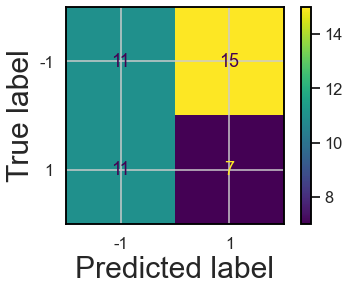


Metabolite: phosphoenolpyruvate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                   max_features=0.6000000000000001,
                                   random_state=42),
    step=0.7000000000000001)), ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]
Confusion matrix:


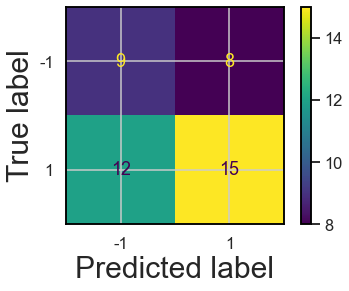


Metabolite: Glycerol-2-phospate
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=GaussianNB())), ('mlpclassifier', MLPClassifier(alpha=0.01, random_state=42))]
Confusion matrix:


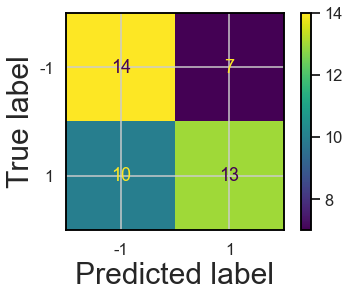


Metabolite: Glycerol-3-phosphate
Optimal classifier: [('featureunion', FeatureUnion(transformer_list=[('stackingestimator',
                                StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                                                       max_depth=4,
                                                                                       max_features=0.1,
                                                                                       min_samples_leaf=15,
                                                                                       min_samples_split=14,
                                                                                       random_state=42,
                                                                                       subsample=0.9000000000000001))),
                               ('functiontransformer',
                                FunctionTransformer(func=<function c

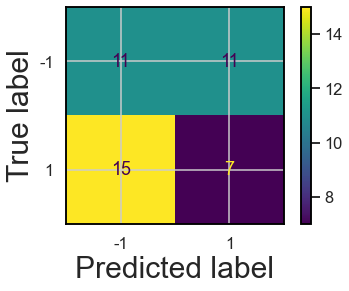


Metabolite: D-erythronate-4-phosphate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy', max_features=1.0,
                                   random_state=42),
    step=0.4)), ('multinomialnb', MultinomialNB(alpha=0.1))]
Confusion matrix:


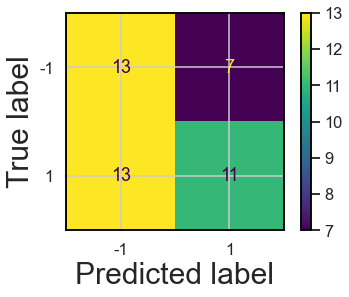

In [10]:
load_seq(msa=False)

for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test(metabolite, threshold=med)
    print()

## Using MSA Aligned Data

In [8]:
from stacking_estimator import StackingEstimator
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from xgboost import XGBClassifier
from copy import copy


msa_pipelines = {
    'ATP': XGBClassifier(learning_rate=0.1, max_depth=4,
                         min_child_weight=13, n_estimators=100,
                         n_jobs=1, subsample=0.9500000000000001,
                         verbosity=0),
    'Blank': make_pipeline(
        StackingEstimator(estimator=MLPClassifier(alpha=0.0001, learning_rate_init=0.001)),
        GaussianNB()
    ),
    'D-erythronate-4-phosphate': make_pipeline(
        StackingEstimator(estimator=SGDClassifier(alpha=0.01, eta0=0.01,
                                                  fit_intercept=False, l1_ratio=0.5,
                                                  learning_rate="invscaling", loss="perceptron",
                                                  penalty="elasticnet", power_t=0.1)),
        StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=True, criterion="gini",
                                                         max_features=0.7000000000000001, min_samples_leaf=20,
                                                         min_samples_split=4, n_estimators=100)),
        StackingEstimator(estimator=KNeighborsClassifier(n_neighbors=12, p=1, weights="distance")),
        StackingEstimator(estimator=LogisticRegression(C=0.1, dual=False, penalty="l2")),
        BernoulliNB(alpha=1.0, fit_prior=False)
    ),
    'D-threonate-4-phosphate': XGBClassifier(learning_rate=0.01, max_depth=10,
                                             min_child_weight=2, n_estimators=100,
                                             n_jobs=1, subsample=1.0, verbosity=0),
    'Glycerol-2-phospate': DecisionTreeClassifier(criterion="entropy", max_depth=3,
                                                  min_samples_leaf=5, min_samples_split=9),
    'Glycerol-3-phosphate': make_pipeline(
        StackingEstimator(estimator=MLPClassifier(alpha=0.1, learning_rate_init=0.001)),
        StackingEstimator(estimator=XGBClassifier(learning_rate=0.1, max_depth=7,
                                                  min_child_weight=16, n_estimators=100,
                                                  n_jobs=1, subsample=0.55, verbosity=0)),
        LinearSVC(C=5.0, dual=True, loss="squared_hinge", penalty="l2", tol=0.1)
    ),
    'L-erythronate-4-phosphate': make_pipeline(
        make_union(
            FunctionTransformer(copy),
            FunctionTransformer(copy)
        ),
        VarianceThreshold(threshold=0.0001),
        BernoulliNB(alpha=1.0, fit_prior=False)
    ),
    'phosphoenolpyruvate': ExtraTreesClassifier(bootstrap=True, criterion="entropy",
                                                max_features=0.25, min_samples_leaf=2,
                                                min_samples_split=9, n_estimators=100),
    'Pyrophosphate': ExtraTreesClassifier(bootstrap=False, criterion="gini",
                                          max_features=0.35000000000000003, min_samples_leaf=18,
                                          min_samples_split=9, n_estimators=100),
    'TTP': make_pipeline(
        StackingEstimator(estimator=MultinomialNB(alpha=10.0, fit_prior=False)),
        XGBClassifier(learning_rate=0.01, max_depth=9,
                      min_child_weight=4, n_estimators=100,
                      n_jobs=1, subsample=0.45, verbosity=0)
    )
}

def set_param_recursive(pipeline_steps, parameter, value):
    """Recursively iterate through all objects in the pipeline and set a given parameter.
    Parameters
    ----------
    pipeline_steps: array-like
        List of (str, obj) tuples from a scikit-learn pipeline or related object
    parameter: str
        The parameter to assign a value for in each pipeline object
    value: any
        The value to assign the parameter to in each pipeline object
    Returns
    -------
    None
    """
    for (_, obj) in pipeline_steps:
        recursive_attrs = ["steps", "transformer_list", "estimators"]
        for attr in recursive_attrs:
            if hasattr(obj, attr):
                set_param_recursive(getattr(obj, attr), parameter, value)
        if hasattr(obj, "estimator"):  # nested estimator
            est = getattr(obj, "estimator")
            if hasattr(est, parameter):
                setattr(est, parameter, value)
        if hasattr(obj, parameter):
            setattr(obj, parameter, value)

In [9]:
def train_test_msa(metabolite_name, threshold=0):
    """
    Run the optimized classifier for the specific metabolite and report the metrics.
    """
    X_train, X_test, y_train, y_test = prepare_train_test(metabolite_name, threshold=threshold)
    clf = msa_pipelines[metabolite_name]
    set_param_recursive(clf.steps, 'random_state', 42)
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    print('Metabolite: {}'.format(metabolite_name))
    print('Optimal classifier: {}'.format(clf.steps))
    print('Confusion matrix:'.format(metabolite_name))
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

Metabolite: Blank
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=DecisionTreeClassifier(max_depth=9,
                                                   min_samples_leaf=10,
                                                   min_samples_split=5,
                                                   random_state=42))), ('sgdclassifier', SGDClassifier(alpha=0.001, eta0=1.0, fit_intercept=False, l1_ratio=0.5,
              learning_rate='invscaling', loss='log', penalty='elasticnet',
              power_t=0.1, random_state=42))]
Confusion matrix:


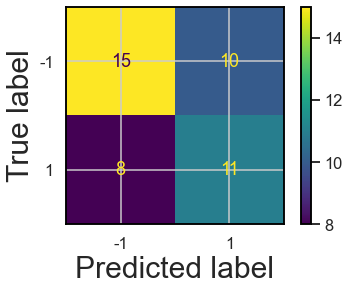


Metabolite: phosphoenolpyruvate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy',
                                   max_features=0.6000000000000001,
                                   random_state=42),
    step=0.7000000000000001)), ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))]
Confusion matrix:


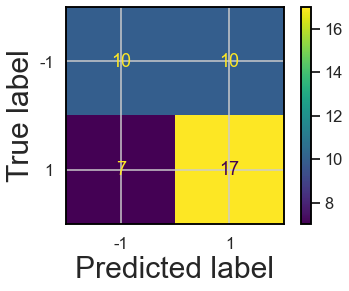


Metabolite: Glycerol-2-phospate
Optimal classifier: [('stackingestimator', StackingEstimator(estimator=GaussianNB())), ('mlpclassifier', MLPClassifier(alpha=0.01, random_state=42))]
Confusion matrix:


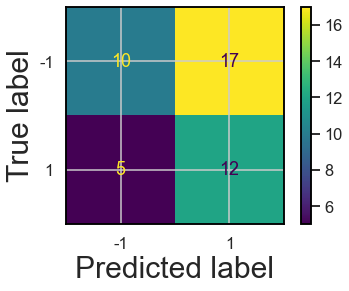


Metabolite: Glycerol-3-phosphate
Optimal classifier: [('featureunion', FeatureUnion(transformer_list=[('stackingestimator',
                                StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=1.0,
                                                                                       max_depth=4,
                                                                                       max_features=0.1,
                                                                                       min_samples_leaf=15,
                                                                                       min_samples_split=14,
                                                                                       random_state=42,
                                                                                       subsample=0.9000000000000001))),
                               ('functiontransformer',
                                FunctionTransformer(func=<function c

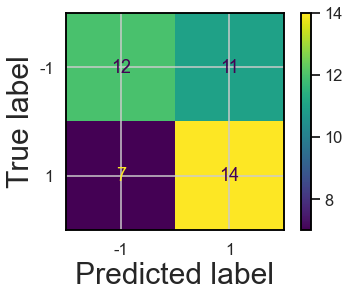


Metabolite: D-erythronate-4-phosphate
Optimal classifier: [('rfe', RFE(estimator=ExtraTreesClassifier(criterion='entropy', max_features=1.0,
                                   random_state=42),
    step=0.4)), ('multinomialnb', MultinomialNB(alpha=0.1))]
Confusion matrix:


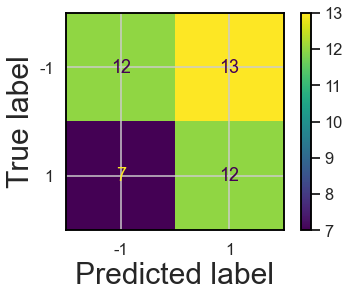

In [16]:
load_seq(msa=True)

for i, metabolite in enumerate(list(metabolite_dict.values())[:5]):
    med = activations.transpose()[i].median()
    train_test_msa(metabolite, threshold=med)
    print()

# Regression
This part is adopted from the work by https://github.com/anaqiafendi/channels/tree/master/regression

In [34]:
def ML_train(X, y):
    # test the optimization of the hyp-prams
    initial_guess = [0.9,0.9]

    # take the log of the initial guess for optimiziation 
    initial_guess_log = np.log(initial_guess)

    # optimize to fit model
    result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X,y), method='L-BFGS-B')
    
    print('Full GP regression model')
    print('Hyperparameters: ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x[1])))

    # next set of hyper prams 
    final_prams = [np.exp(result.x[0]), np.exp(result.x[1])]
    
    return final_prams

def ML_predict(X, y, X_true_test, y_true_test, log_data, final_prams, property_, num_iter=1, Substrate_ID=0, metabolite_dict=metabolite_dict):
    substrate = list(metabolite_dict.values())[Substrate_ID]
    
    if not os.path.exists('outputs/loop_figs/' + str(substrate) + '/'):
        os.makedirs('outputs/loop_figs/' + str(substrate) + '/')

    path_outputs = 'outputs/loop_figs/' + str(substrate) + '/'

    # next use trained GP model to predict full test set
    mu_true_test, var_true_test = GP.predict_GP(X, y, X_true_test, final_prams)

    # convert the true test predications and y back to unnormalized data
    y_test_real = np.exp(y_true_test*np.std(log_data)  + np.mean(log_data))
    mu_test_real = np.exp(mu_true_test*np.std(log_data)  + np.mean(log_data))

    if property_ != 'kinetics_off':
        
        par = np.polyfit(y_test_real, mu_test_real, 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        
        # coefficient of determination, plot text
        variance = np.var(mu_test_real)
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(y_test_real, mu_test_real)])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set for {}'.format(str(substrate)))
        print('R = %0.3f'% np.sqrt(Rsqr))
        
        # plot and measure correlation
        plt.figure('True test', figsize=(1.5, 1.5))
        plt.plot(y_test_real, mu_test_real, 'o', ms=3, color='k')
        
        max_x = np.max(y_test_real)
        plt.plot([0, max_x], [intercept, slope*max_x+intercept], '-', color='k')
        plt.suptitle('R = %0.3f'% np.sqrt(Rsqr))
        plt.savefig(path_outputs + str(property_)+'_matern_kernel_'+str(num_iter)+'.png', bbox_inches='tight', transparent=False, dpi=300)
        
        plt.show()

    elif property_ == 'kinetics_off':
        
        par = np.polyfit(np.log10(y_test_real), np.log10(mu_test_real), 1, full=True)
        slope=par[0][0]
        intercept=par[0][1]
        
        # coefficient of determination, plot text
        variance = np.var(np.log10(mu_test_real))
        residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(np.log10(y_test_real), np.log10(mu_test_real))])
        Rsqr = np.round(1-residuals/variance, decimals=2)
        print('GP regression model test set for {}'.format(str(substrate)))
        print('R = %0.3f'% np.sqrt(Rsqr))
        
        # plot and measure correlation
        plt.figure('True test', figsize=(1.5, 1.5))
        plt.plot(np.log10(y_test_real), np.log10(mu_test_real), 'o',  ms=3, color='k')
        
        max_x = np.max(y_test_real)
        min_x = np.min(y_test_real)
        
        plt.plot([np.log10(min_x), np.log10(max_x)], [np.log10(slope*min_x+intercept), np.log10(slope*max_x+intercept)], '-', color='k')
        
        plt.savefig(path_outputs + str(property_)+'_matern_kernel_'+str(num_iter)+'.png', bbox_inches='tight', transparent=True)
        # plt.show()

    # df_select_test_not_defined
    df_select_test = pd.DataFrame(columns=['y','mu','y_real','mu_real'])

    # export csv with predicted values
    df_select_test['y'] = y_true_test
    df_select_test['mu'] = mu_true_test
    df_select_test['y_real'] = y_test_real
    df_select_test['mu_real'] = mu_test_real

    df_select_test.to_csv(path_outputs+ 'matern_kernel_'+str(num_iter)+'_'+str(property_)+'.csv')
    return

def data_format(X, y):
    # test data only includes gen 10
    # df_test_data = df[df.gen == 10]

    # training data excludes test data (gen 10)
    # df_data = df[df.gen != 10]

    # Clean 0 y data which skews results when having to convert infs
    X = X[y != 0]
    y = y[y != 0]

    # Use random split of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # normalize training data
    log_data = np.log(y_train)

    y_train = (log_data - np.mean(log_data))/np.std(log_data)
    # seq = df_select.seq.values

    # normalize test data
    log_data_test = np.log(y_test)
    y_test = (log_data_test - np.mean(log_data))/np.std(log_data)
    # seq_test = df_select_test.seq.values

    return log_data, X_train, X_test, y_train, y_test 
    
    # seq_test, df_select, df_select_test
    
def prep_inputs(Protein_seq_dict,EFI_ID_List,activations,Substrate_ID=0,trim_long=False):
    
    # Trim length of protein sequences first
    if trim_long == True:
        Trimmed_dict = {}
        New_ID_List = []
        for ID in EFI_ID_List:
            if len(Protein_seq_dict[int(ID)]) <= 300:
                Trimmed_dict[int(ID)] = Protein_seq_dict[int(ID)]
                New_ID_List.append(int(ID))
        Protein_seq_dict = Trimmed_dict
        EFI_ID_List = New_ID_List
    
    # Need to pad protein sequences to the max length of the longest one
    max_len = len(max(Protein_seq_dict.values(), key=len))
    fillchar = '-' # This is whats used in the GP-UCB paper
    Padded_dict = {}
    OH_dict = {}
    for ID in EFI_ID_List:
        Padded_dict[int(ID)] = Protein_seq_dict[int(ID)].upper().ljust(max_len, fillchar)
        OH_dict[int(ID)] = encoding_tools.one_hot_seq(seq_input=Padded_dict[int(ID)])

    # Preparing input training data X to feed into ML Model
    input_len = len(OH_dict[EFI_ID_List[0]])*21
    num_inputs = len(OH_dict.keys())

    X = np.zeros((num_inputs,input_len))
    for i in range(0,len(EFI_ID_List)):
        ID = EFI_ID_List[i]
        X_seq = OH_dict[int(ID)]
        X_seq = np.reshape(X_seq,(1,X_seq.shape[0]*21))
        X[i,:] = X_seq

    # Preapre output training data y to feed into ML Model
    dummy = [str(ID) for ID in EFI_ID_List]
    y = activations[dummy].values[Substrate_ID,:]

    return X, y

In [32]:
def auto_train_test(Protein_seq_dict, EFI_ID_List, activations, Substrate_ID, num_iter, metabolite_dict=metabolite_dict):
    # Need to prep inputs X and Y
    X, y = prep_inputs(Protein_seq_dict,EFI_ID_List,activations,Substrate_ID=Substrate_ID,trim_long=True)

    # Format data for train and test splits
    log_data, X_train, X_test, y_train, y_test = data_format(X, y)

    # Train ML Model on training set
    final_prams = ML_train(X_train, y_train)

    # Predict on test set
    ML_predict(X=X_train, y=y_train, X_true_test=X_test, y_true_test=y_test, log_data=log_data, final_prams=final_prams, property_='activity', num_iter=num_iter, Substrate_ID=Substrate_ID, metabolite_dict=metabolite_dict)

Full GP regression model
Hyperparameters: 0.0012275126375166311 5.009901624614196
GP regression model test set for Blank
R = 0.141


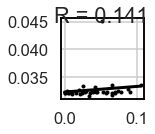

Full GP regression model
Hyperparameters: 0.0006399625879515414 4.088545105550032
GP regression model test set for phosphoenolpyruvate
R = 0.200


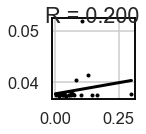

Full GP regression model
Hyperparameters: 0.04365524221879044 9.298146409008712
GP regression model test set for Glycerol-2-phospate
R = 0.141


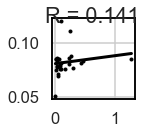

Full GP regression model
Hyperparameters: 6.587926105164977e-06 7.541958248247304
GP regression model test set for Glycerol-3-phosphate
R = 0.100


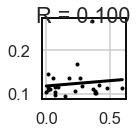

Full GP regression model
Hyperparameters: 2.192349213451267e-06 4.188260414428765
GP regression model test set for D-erythronate-4-phosphate
R = 0.000


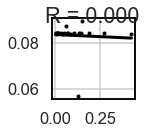

In [42]:
for j in range(0,5):
    try:
        auto_train_test(Protein_seq_dict, EFIs, activations, Substrate_ID=j, num_iter=20)
    except np.linalg.LinAlgError:
        print('LinAlgError, negative value in eigenvector')